In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-01 16:15:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.204.80, 142.250.204.144, 142.250.66.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.204.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.08s   

2021-05-01 16:15:38 (828 KB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [ 96.7 104.3 116.7  92.8 141.7]
time: [0 1 2 3 4]


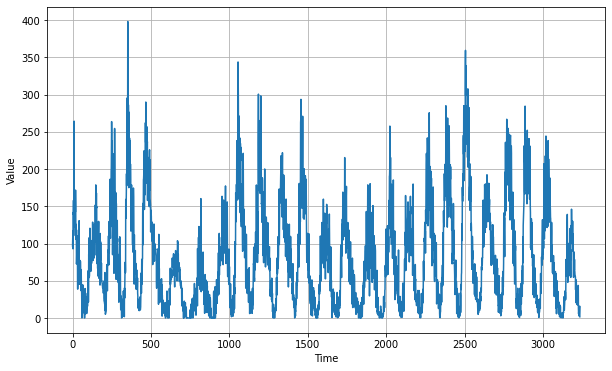

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(3000,)


In [9]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [10]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 100ms/step - loss: 38.9182 - mae: 39.4146
Epoch 2/500
30/30 [==============================] - 3s 98ms/step - loss: 25.7631 - mae: 26.2575
Epoch 3/500
30/30 [==============================] - 3s 109ms/step - loss: 22.0827 - mae: 22.5764
Epoch 4/500
30/30 [==============================] - 4s 117ms/step - loss: 20.4713 - mae: 20.9643
Epoch 5/500
30/30 [==============================] - 4s 134ms/step - loss: 19.7339 - mae: 20.2263
Epoch 6/500
30/30 [==============================] - 3s 98ms/step - loss: 19.3347 - mae: 19.8268
Epoch 7/500
30/30 [==============================] - 3s 100ms/step - loss: 18.7302 - mae: 19.2224
Epoch 8/500
30/30 [==============================] - 3s 103ms/step - loss: 18.1358 - mae: 18.6273
Epoch 9/500
30/30 [==============================] - 3s 101ms/step - loss: 18.0753 - mae: 18.5669
Epoch 10/500
30/30 [==============================] - 4s 136ms/step - loss: 18.3835 - mae: 18.8747
Epoch 11/500
30/30 [=

Epoch 84/500
30/30 [==============================] - 3s 97ms/step - loss: 16.3604 - mae: 16.8487
Epoch 85/500
30/30 [==============================] - 3s 98ms/step - loss: 16.4162 - mae: 16.9051
Epoch 86/500
30/30 [==============================] - 3s 97ms/step - loss: 16.8775 - mae: 17.3667
Epoch 87/500
30/30 [==============================] - 3s 98ms/step - loss: 16.5678 - mae: 17.0567
Epoch 88/500
30/30 [==============================] - 3s 97ms/step - loss: 16.4625 - mae: 16.9517
Epoch 89/500
30/30 [==============================] - 3s 98ms/step - loss: 16.6528 - mae: 17.1416
Epoch 90/500
30/30 [==============================] - 3s 100ms/step - loss: 16.3909 - mae: 16.8792
Epoch 91/500
30/30 [==============================] - 3s 97ms/step - loss: 16.4120 - mae: 16.9008
Epoch 92/500
30/30 [==============================] - 3s 96ms/step - loss: 16.3566 - mae: 16.8449
Epoch 93/500
30/30 [==============================] - 3s 97ms/step - loss: 16.3729 - mae: 16.8619
Epoch 94/500
30/30 

30/30 [==============================] - 3s 95ms/step - loss: 15.8859 - mae: 16.3745
Epoch 167/500
30/30 [==============================] - 3s 93ms/step - loss: 15.9351 - mae: 16.4238
Epoch 168/500
30/30 [==============================] - 3s 95ms/step - loss: 16.0402 - mae: 16.5290
Epoch 169/500
30/30 [==============================] - 3s 94ms/step - loss: 15.8469 - mae: 16.3353
Epoch 170/500
30/30 [==============================] - 3s 95ms/step - loss: 16.0180 - mae: 16.5068
Epoch 171/500
30/30 [==============================] - 3s 94ms/step - loss: 15.8613 - mae: 16.3497
Epoch 172/500
30/30 [==============================] - 3s 94ms/step - loss: 15.9019 - mae: 16.3904
Epoch 173/500
30/30 [==============================] - 3s 97ms/step - loss: 15.8745 - mae: 16.3631
Epoch 174/500
30/30 [==============================] - 3s 94ms/step - loss: 16.0192 - mae: 16.5082
Epoch 175/500
30/30 [==============================] - 3s 96ms/step - loss: 15.9290 - mae: 16.4177
Epoch 176/500
30/30 [===

30/30 [==============================] - 3s 99ms/step - loss: 15.6764 - mae: 16.1646
Epoch 249/500
30/30 [==============================] - 3s 96ms/step - loss: 15.6346 - mae: 16.1227
Epoch 250/500
30/30 [==============================] - 3s 96ms/step - loss: 15.4774 - mae: 15.9649
Epoch 251/500
30/30 [==============================] - 3s 95ms/step - loss: 15.5285 - mae: 16.0160
Epoch 252/500
30/30 [==============================] - 3s 96ms/step - loss: 15.5817 - mae: 16.0695
Epoch 253/500
30/30 [==============================] - 3s 95ms/step - loss: 15.4473 - mae: 15.9344
Epoch 254/500
30/30 [==============================] - 3s 97ms/step - loss: 15.4618 - mae: 15.9495
Epoch 255/500
30/30 [==============================] - 3s 97ms/step - loss: 15.4277 - mae: 15.9148
Epoch 256/500
30/30 [==============================] - 3s 101ms/step - loss: 15.4627 - mae: 15.9502
Epoch 257/500
30/30 [==============================] - 3s 98ms/step - loss: 15.4065 - mae: 15.8936
Epoch 258/500
30/30 [==

30/30 [==============================] - 3s 100ms/step - loss: 15.2437 - mae: 15.7306
Epoch 331/500
30/30 [==============================] - 3s 95ms/step - loss: 15.1165 - mae: 15.6030
Epoch 332/500
30/30 [==============================] - 3s 96ms/step - loss: 15.1518 - mae: 15.6384
Epoch 333/500
30/30 [==============================] - 4s 120ms/step - loss: 15.1417 - mae: 15.6285
Epoch 334/500
30/30 [==============================] - 3s 109ms/step - loss: 15.0071 - mae: 15.4934
Epoch 335/500
30/30 [==============================] - 3s 95ms/step - loss: 15.0215 - mae: 15.5079
Epoch 336/500
30/30 [==============================] - 3s 95ms/step - loss: 15.0910 - mae: 15.5778
Epoch 337/500
30/30 [==============================] - 3s 94ms/step - loss: 15.1314 - mae: 15.6182
Epoch 338/500
30/30 [==============================] - 3s 94ms/step - loss: 15.2337 - mae: 15.7203
Epoch 339/500
30/30 [==============================] - 3s 96ms/step - loss: 15.1272 - mae: 15.6140
Epoch 340/500
30/30 [

30/30 [==============================] - 3s 102ms/step - loss: 14.8427 - mae: 15.3291
Epoch 413/500
30/30 [==============================] - 3s 99ms/step - loss: 14.7950 - mae: 15.2813
Epoch 414/500
30/30 [==============================] - 3s 97ms/step - loss: 14.7964 - mae: 15.2826
Epoch 415/500
30/30 [==============================] - 3s 97ms/step - loss: 14.8989 - mae: 15.3855
Epoch 416/500
30/30 [==============================] - 3s 97ms/step - loss: 15.2395 - mae: 15.7270
Epoch 417/500
30/30 [==============================] - 3s 97ms/step - loss: 14.7410 - mae: 15.2268
Epoch 418/500
30/30 [==============================] - 3s 97ms/step - loss: 14.7722 - mae: 15.2580
Epoch 419/500
30/30 [==============================] - 3s 98ms/step - loss: 14.7467 - mae: 15.2326
Epoch 420/500
30/30 [==============================] - 3s 95ms/step - loss: 14.8712 - mae: 15.3576
Epoch 421/500
30/30 [==============================] - 3s 96ms/step - loss: 14.8270 - mae: 15.3132
Epoch 422/500
30/30 [==

30/30 [==============================] - 3s 96ms/step - loss: 14.4249 - mae: 14.9106
Epoch 495/500
30/30 [==============================] - 3s 96ms/step - loss: 14.6156 - mae: 15.1019
Epoch 496/500
30/30 [==============================] - 3s 96ms/step - loss: 14.4808 - mae: 14.9668
Epoch 497/500
30/30 [==============================] - 3s 96ms/step - loss: 14.5462 - mae: 15.0325
Epoch 498/500
30/30 [==============================] - 3s 95ms/step - loss: 14.4769 - mae: 14.9627
Epoch 499/500
30/30 [==============================] - 3s 97ms/step - loss: 14.6500 - mae: 15.1364
Epoch 500/500
30/30 [==============================] - 3s 95ms/step - loss: 14.3715 - mae: 14.8569


<Figure size 432x288 with 0 Axes>

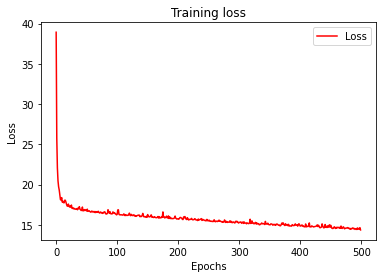

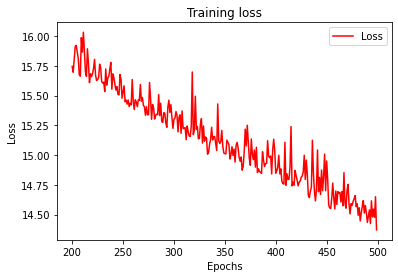

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()


zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

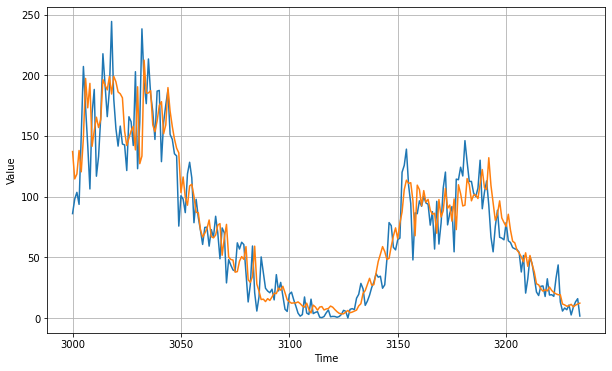

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.532999